In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Load the dataset
file_path = 'Merged_HKSL_with_all_features.csv'
data = pd.read_csv(file_path)

# 2. Convert 'TIME' column to datetime (if applicable)
if 'TIME' in data.columns:
    data['TIME'] = pd.to_datetime(data['TIME'])

# 3. Keep the 'TIME' column for later (before dropping unnecessary columns)
time_column = data['TIME']  # Save the time column for future plotting

# 4. Drop unnecessary columns (non-numeric and datetime)
columns_to_drop = ['TIME', 'PRN', 'Signal Type 1', 'Signal Type 2', 'C1 Code', 'C2 Code']
data = data.drop(columns=columns_to_drop)

# 5. Separate features and target
X = data.drop(columns=['Pseudorange Residual (m)'])  # Features
y = data['Pseudorange Residual (m)']  # Target

# 6. Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(X, y, time_column, test_size=0.2, random_state=42)

# 7. Standardize/Scale the numeric features (only numeric columns)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. Reshape the data for CNN input (CNN expects 3D input: [samples, timesteps, features])
# Adding an extra dimension to match CNN input requirements
X_train_cnn = np.expand_dims(X_train_scaled, axis=2)
X_test_cnn = np.expand_dims(X_test_scaled, axis=2)

# Check the shape of the data prepared for CNN
print("X_train_cnn shape:", X_train_cnn.shape)
print("X_test_cnn shape:", X_test_cnn.shape)

X_train_cnn shape: (300403, 23, 1)
X_test_cnn shape: (75101, 23, 1)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_cnn(input_shape):
    model = Sequential()
    
    # First Convolutional Layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    
    # Second Convolutional Layer
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    
    # Third Convolutional Layer
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    
    # Flattening and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))  # Dropout to prevent overfitting
    model.add(Dense(1))  # Output layer for regression
    
    # Compile the model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# 9. Create the model
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])
cnn_model = create_cnn(input_shape)

# 10. Train the CNN model
cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_data=(X_test_cnn, y_test))

Epoch 1/50


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9388/9388 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.4107 - val_loss: 0.0146
Epoch 2/50
9388/9388 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0332 - val_loss: 0.0076
Epoch 3/50
9388/9388 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0214 - val_loss: 0.0051
Epoch 4/50
9388/9388 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.0167 - val_loss: 0.0046
Epoch 5/50
9388/9388 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0144 - val_loss: 0.0037
Epoch 6/50
9388/9388 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0132 - val_loss: 0.0035
Epoch 7/50
9388/9388 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0122 - val_loss: 0.0037
Epoch 8/50
9388/9388 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0114 - val_loss: 0.0024
Epoch 9/50
9388/9388 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0110 - val_loss: 0.0030
Epoch 10/50
9388/9388 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0106 - val_loss: 0.0029
Epoch 11/50
9388/9388 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0103 - val_loss: 0.0027
Epoch 12/50
9388/9388 ━━━━━━━━

In [16]:
# 11. Predict the values with the trained CNN model
y_pred_cnn = cnn_model.predict(X_test_cnn)

2347/2347 ━━━━━━━━━━━━━━━━━━━━ 2s 794us/step


In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Ensure that y_pred_cnn is 1-dimensional
y_pred_cnn = y_pred_cnn.flatten()  # Flatten the array to 1D if needed

# Check shapes of y_test and y_pred_cnn
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred_cnn: {y_pred_cnn.shape}")

# Step 1: Calculate RMS of the original Pseudorange Residual (a1)
a1 = np.sqrt(mean_squared_error(np.zeros_like(y_test), y_test))  # RMS(Residual_Original)

# Step 2: Calculate the corrected residual (M_c = Residual_Original - Predicted Residual)
M_c = y_test - y_pred_cnn

# Step 3: Calculate RMS of the corrected residual (a2)
a2 = np.sqrt(mean_squared_error(np.zeros_like(M_c), M_c))  # RMS(M_c)

# Step 4: Calculate the improvement rate
improvement_rate = (a1 - a2) / a1 * 100

# Print the results
print(f'RMS of Original Residual (a1): {a1:.4f} meters')
print(f'RMS of Corrected Residual (a2): {a2:.4f} meters')
print(f'Improvement Rate: {improvement_rate:.2f}%')


Shape of y_test: (75101,)
Shape of y_pred_cnn: (75101,)
RMS of Original Residual (a1): 0.7960 meters
RMS of Corrected Residual (a2): 0.0373 meters
Improvement Rate: 95.32%


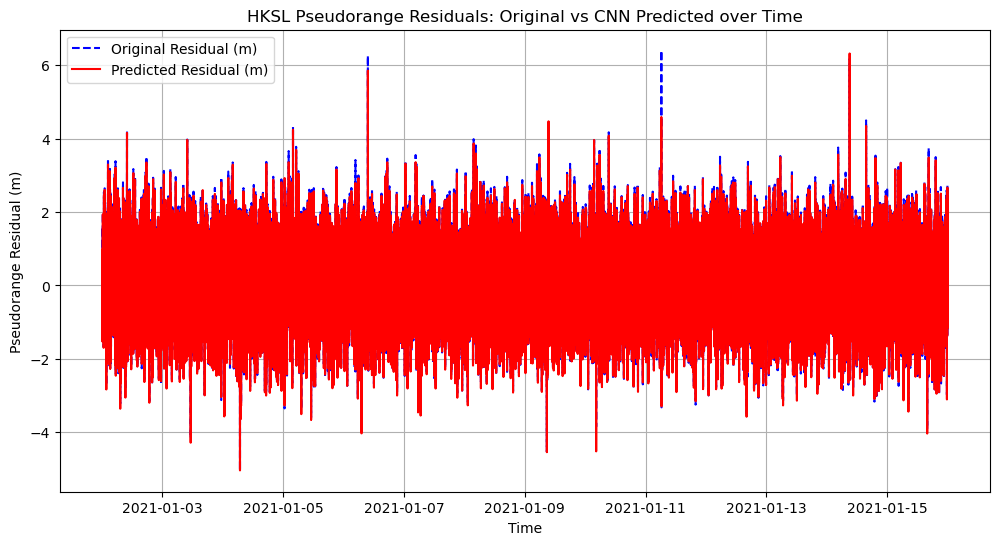

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Ensure y_test and y_pred_cnn have the same index alignment
y_test = y_test.reset_index(drop=True)
y_pred_cnn = pd.Series(y_pred_cnn.flatten())  # Flatten the predictions and convert to pandas series

# Ensure the time_test is aligned properly with y_test
time_test = time_test.reset_index(drop=True)

# Sort the data by time (if needed)
sorted_indices = time_test.argsort()
y_test = y_test[sorted_indices]
y_pred_cnn = y_pred_cnn[sorted_indices]
time_test = time_test[sorted_indices]

# Now plot
plt.figure(figsize=(12, 6))
plt.plot(time_test, y_test, label='Original Residual (m)', color='blue', linestyle='--')
plt.plot(time_test, y_pred_cnn, label='Predicted Residual (m)', color='red')
plt.title('HKSL Pseudorange Residuals: Original vs CNN Predicted over Time')
plt.xlabel('Time')
plt.ylabel('Pseudorange Residual (m)')
plt.legend()
plt.grid(True)
plt.show()

